<a href="https://colab.research.google.com/github/aatika-hakim/chatbots/blob/main/customer_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q langgraph langchain_google_genai langchain_community

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [7]:
graph_builder = StateGraph(State)

In [8]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
# llm.invoke("hi").content
from google.colab import userdata

api_key = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=1, api_key= api_key)
llm.invoke("hi").content

TimeoutException: Requesting secret GROQ_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

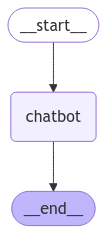

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [12]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [ ]:
import re

# Define customer support keywords or intents
SUPPORT_KEYWORDS = [
    "complaint", "refund", "support", "issue", "problem",
    "help", "order", "billing", "payment", "service"
]

# Function to check if input is a customer support query
def is_customer_support_query(user_input):
    user_input = user_input.lower()
    return any(keyword in user_input for keyword in SUPPORT_KEYWORDS)

# Function to process customer support queries
def handle_customer_support(user_input):
    if "complaint" in user_input:
        return "Please describe your issue, including the product and your preferred resolution."
    elif "refund" in user_input:
        return "To process a refund, we need the order ID and the reason for the refund."
    elif "help" in user_input:
        return "How can I assist you today? You can ask about complaints, refunds, or other support issues."
    else:
        return "Can you provide more details about your support request?"

# Main chatbot loop
def customer_support_chatbot():
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye! Have a great day!")
                break

            # Check if the input is a valid support query
            if is_customer_support_query(user_input):
                response = handle_customer_support(user_input)
            else:
                response = "I'm here to assist with customer support issues only. Please ask a relevant question."

            print("Chatbot:", response)

        except Exception as e:
            print(f"Error: {str(e)}")
            break

# Run the chatbot
customer_support_chatbot()


In [6]:
!pip install -q streamlit langchain_anthropic gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00


In [5]:
import streamlit as st
from langchain.memory import ConversationBufferMemory
from langchain.tools import tool
from langchain_anthropic import ChatAnthropic
from langchain.agents import AgentExecutor, Tool
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from google.colab import userdata
import os

# Load environment variables and set OpenAI API key

os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

# Setup LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Memory setup
memory = ConversationBufferMemory(return_messages=True)

# Define the state structure
class State(TypedDict):
    query: str
    category: str
    response: str

# Restaurant-specific tools

@tool
def menu_search(state: State) -> str:
    """Provide information about menu items or specials."""
    menu_query = state.get("query", "").strip()
    if not menu_query:
        return "Please provide a specific menu item or query."

    # Simulate menu search
    menu_items = ["Pizza", "Burger", "Pasta", "Salad", "Dessert"]
    if menu_query.lower() in [item.lower() for item in menu_items]:
        return f"Here's information about {menu_query}."
    return "Sorry, we couldn't find that item on the menu."

@tool
def order_status(state: State) -> str:
    """Track or modify a customer's order."""
    order_id = state.get("query", "").strip()
    if not order_id:
        return "Please provide your order ID."

    # Simulate order status lookup
    return f"Your order {order_id} is being prepared and should arrive shortly."

@tool
def reservation_tool(state: State) -> str:
    """Handle restaurant reservations."""
    reservation_query = state.get("query", "").strip()
    if not reservation_query:
        return "Please provide details like the number of people and time for your reservation."

    # Simulate reservation handling
    return f"Your reservation for {reservation_query} has been confirmed."

@tool
def feedback_complaints(state: State) -> str:
    """Handle customer complaints or feedback."""
    feedback = state.get("query", "").strip()
    if not feedback:
        return "Please provide details of your complaint or feedback."

    # Simulate handling feedback
    return f"Thank you for your feedback! We will look into it shortly."

# Tools
tools = [
    Tool(name="menu_search", func=menu_search, description="Search the menu for items or specials."),
    Tool(name="order_status", func=order_status, description="Check the status of an order."),
    Tool(name="reservation_tool", func=reservation_tool, description="Make or modify restaurant reservations."),
    Tool(name="feedback_complaints", func=feedback_complaints, description="Handle complaints or feedback."),
]

# Agent Executor
agent = AgentExecutor(agent=llm, tools=tools, verbose=True)

def use_tool(state: State) -> State:
    """Use LangChain tools to handle specific tasks."""
    query = state["query"]
    try:
        response = agent.run(query)
        state["response"] = response
    except Exception as e:
        state["response"] = f"An error occurred: {str(e)}"
    return state

# Categorize restaurant queries
def categorize_query(state: State) -> State:
    """Categorize the query into relevant restaurant support categories."""
    prompt = ChatPromptTemplate.from_template(
        """
        Categorize the following query into one of these categories:
        'Menu Inquiry', 'Order Issues', 'Reservation', 'Feedback/Complaints', or 'General Assistance'.
        Query: {query}

        Conversation History:
        {history}
        """
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["category"] = category
    memory.save_context({"Human": state["query"]}, {"AI": category})
    return state

# Routing logic
def route_query(state: State) -> str:
    """Route the query based on its category."""
    category = state.get("category", "")
    if category == "Menu Inquiry":
        return "menu_search"
    elif category == "Order Issues":
        return "order_status"
    elif category == "Reservation":
        return "reservation_tool"
    elif category == "Feedback/Complaints":
        return "feedback_complaints"
    else:
        return "handle_general_assistance"

# Handle general assistance
def handle_general_assistance(state: State) -> State:
    """Provide general assistance for restaurant-related queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide general assistance for the following query: {query}\n\nConversation History:\n{history}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["response"] = response
    memory.save_context({"Human": state["query"]}, {"AI": response})
    return state

# Workflow setup
workflow = StateGraph(State)
workflow.add_node("categorize_query", categorize_query)
workflow.add_node("menu_search", menu_search)
workflow.add_node("order_status", order_status)
workflow.add_node("reservation_tool", reservation_tool)
workflow.add_node("feedback_complaints", feedback_complaints)
workflow.add_node("handle_general_assistance", handle_general_assistance)
workflow.add_edge(START, "categorize_query")
workflow.add_conditional_edges(
    "categorize_query", route_query,
    ["menu_search", "order_status", "reservation_tool", "feedback_complaints", "handle_general_assistance"], END
)

app = workflow.compile()


In [ ]:
# Streamlit UI Setup
st.set_page_config(page_title="Restaurant Customer Support", page_icon="🍽️", layout="wide")
st.title("🍽️ Restaurant Customer Support Chatbot")
st.write("Welcome! I'm here to assist you with menu inquiries, order issues, reservations, feedback, and more.")

# Sidebar setup
st.sidebar.title("🍴 Support Options")
st.sidebar.header("Choose an option:")
st.sidebar.markdown("""
- **Menu Inquiry**: Get details on our menu items.
- **Order Issues**: Track or modify your order.
- **Reservation**: Make or change your reservation.
- **Feedback/Complaints**: Let us know about your experience.
- **General Assistance**: Ask anything else.
""")

# User chat interface
if "history" not in st.session_state:
    st.session_state.history = []

# Display chat history
def display_chat():
    for message in st.session_state.history:
        role = message["role"]
        if role == "user":
            st.chat_message("user").markdown(message["content"])
        elif role == "assistant":
            st.chat_message("assistant").markdown(message["content"])

# Input handler
query = st.chat_input("💬 Type your question here...")
if query:
    # Append user message to history
    st.session_state.history.append({"role": "user", "content": query})

    # Process query and route to appropriate function
    state = {"query": query, "category": "", "response": ""}
    result = app.invoke(state)

    # Append AI response to history
    st.session_state.history.append({"role": "assistant", "content": result["response"]})

# Display updated chat
display_chat()

# Reset conversation
if st.sidebar.button("🔄 Reset Conversation"):
    st.session_state.history.clear()
    st.sidebar.success("Conversation reset successfully!")